In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

def encode_dct(img, text, channel=0, intensity=20):
    block_size = 8
    height, width = img.shape[:2]
    grid_width = width // block_size
    grid_height = height // block_size

    text_bytes = text.encode('utf-8')
    length = len(text_bytes)
    bit_stream = [int(b) for b in format(length, '032b')]  
    for byte in text_bytes:
        bit_stream += [int(b) for b in format(byte, '08b')]

    max_bits = (grid_width - 1) * (grid_height - 1)
    if len(bit_stream) > max_bits:
        raise ValueError("Message too large for image.")

    img = img.astype(np.float32)
    planes = cv2.split(img)

    i = 0
    for y in range(1, grid_height):
        for x in range(1, grid_width):
            if i >= len(bit_stream):
                break

            px = (x - 1) * block_size
            py = (y - 1) * block_size
            block = planes[channel][py:py+block_size, px:px+block_size]
            dct_block = cv2.dct(block)

            a, b = dct_block[4, 3], dct_block[3, 4]
            bit = bit_stream[i]

            if bit == 0 and a < b:
                a, b = b, a
            elif bit == 1 and a > b:
                a, b = b, a

            if abs(a - b) < intensity:
                diff = (intensity - abs(a - b)) / 2
                if bit == 0:
                    a += diff
                    b -= diff
                else:
                    a -= diff
                    b += diff

            dct_block[4, 3] = a
            dct_block[3, 4] = b
            planes[channel][py:py+block_size, px:px+block_size] = cv2.idct(dct_block)
            i += 1

    encoded = cv2.merge(planes)
    return np.clip(encoded, 0, 255).astype(np.uint8)

def decode_dct(img, channel=0):
    block_size = 8
    height, width = img.shape[:2]
    grid_width = width // block_size
    grid_height = height // block_size

    img = img.astype(np.float32)
    planes = cv2.split(img)

    bits = []
    for y in range(1, grid_height):
        for x in range(1, grid_width):
            px = (x - 1) * block_size
            py = (y - 1) * block_size
            block = planes[channel][py:py+block_size, px:px+block_size]
            dct_block = cv2.dct(block)

            a, b = dct_block[4, 3], dct_block[3, 4]
            bits.append(1 if a < b else 0)

    length_bits = bits[:32]
    length = int("".join(map(str, length_bits)), 2)
    message_bits = bits[32:32+8*length]

    chars = []
    for i in range(0, len(message_bits), 8):
        byte = message_bits[i:i+8]
        chars.append(chr(int("".join(map(str, byte)), 2)))

    return ''.join(chars)




img = cv2.imread('treeBW.png')

# Encoding
hidden = encode_dct(img, "Hello from JKLU")

cv2.imwrite('hidden.png', hidden)


True

In [6]:

loaded_img = cv2.imread('hidden.png')

# Decoding
message = decode_dct(loaded_img)
print("Decoded message:", message)

Decoded message: Hello from JKLU


MSE: 0.0044252747, PSNR: 71.6714 dB


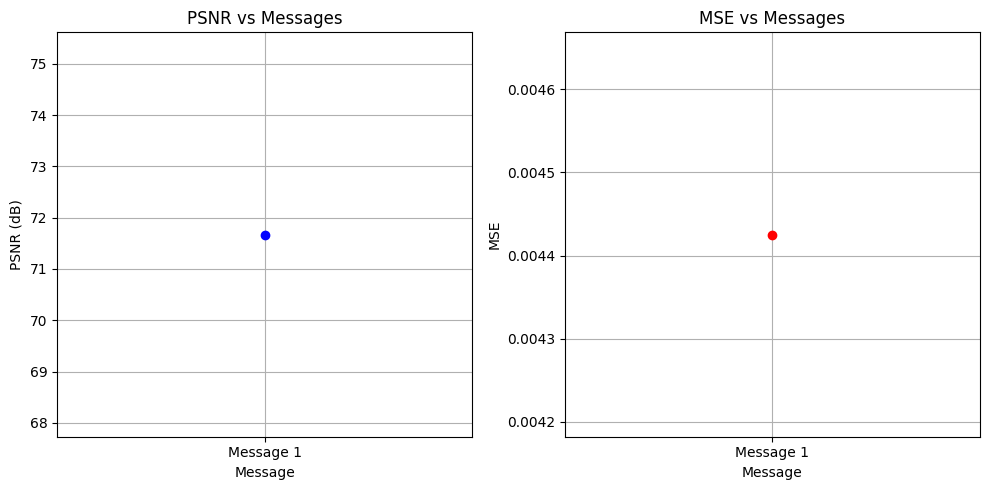

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_mse_psnr(original, modified):
    original = original.astype(np.float32)
    modified = modified.astype(np.float32)

    mse = np.mean((original - modified) ** 2)
    if mse == 0:
        psnr = float('inf')
    else:
        max_pixel = 255.0
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    return mse, psnr

original = cv2.imread("treeBW.png", cv2.IMREAD_GRAYSCALE)
hidden = cv2.imread("hidden.png", cv2.IMREAD_GRAYSCALE)

mse, psnr = calculate_mse_psnr(original, hidden)

psnr_values = [psnr]
mse_values = [mse]
message_labels = ["Message 1"]

print(f"MSE: {mse:.10f}, PSNR: {psnr:.4f} dB")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(message_labels, psnr_values, marker='o', color='blue')
plt.title('PSNR vs Messages')
plt.xlabel('Message')
plt.ylabel('PSNR (dB)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(message_labels, mse_values, marker='o', color='red')
plt.title('MSE vs Messages')
plt.xlabel('Message')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()
